## Gradient Descent

# We will solve a simple linear regression problem by gradient descent.  
We will see the effect of the learning rate on the trajectory in parameter space.
We will show how Stochastic Gradient Descent (SGD) differs from the standard version, and the effect of "shuffling" your data during SGD.

1. Stochastic Gradient Descent
2. Batch Gradient Descent
3. Mini-batch Gradient Descent

In [1]:
# Preliminaries - packages to load

# from _future_ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %matplotlib inline

In [2]:
# %config IPCompleter.greedy=True

## Generate Data from a known distribution
Below we will generate data a known distribution.  
Specifically, the true model is:

$Y = b + \theta_1 X_1 + \theta_2 X_2 + \epsilon$

$X_1$ and $X_2$ have a uniform distribution on the interval $[0,10]$, while `const` is a vector of ones (representing the intercept term).

We set actual values for $b$ ,$\theta_1$, and $\theta_2$

Here $b=1.5$, $\theta_1=2$, and $\theta_2=5$

We then generate a vector of $y$-values according to the model and put the predictors together in a "feature matrix" `x_mat`

In [3]:
np.random.seed(1234)  ## This ensures we get the same data if all of the other parameters remain fixed

num_obs = 100

x1 = np.random.uniform(0,10,num_obs)
x2 = np.random.uniform(0,10,num_obs)
const = np.ones(num_obs)
eps = np.random.normal(0,.5,num_obs)


In [5]:
b = 1.5
theta_1 = 2
theta_2 = 5
y = b*const+ theta_1*x1 + theta_2*x2 + eps
x_mat = np.array([const,x1,x2]).T

## Get the "Right" answer directly
In the below cells we solve for the optimal set of coefficients.  Note that even though the true model is given by:

$b=1.5$, $\theta_1=2$, and $\theta_2=5$

The maximum likelihood (least-squares) estimate from a finite data set may be slightly different.

## Exercise:
Solve the problem two ways:
1. By using the scikit-learn LinearRegression model
2. Using matrix algebra directly via the formula $\theta = (X^T X)^{-1}X^Ty$

Note: The scikit-learn solver may give a warning message, this can be ignored.

In [6]:
### Solve directly using sklearn
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression(fit_intercept=False)
lr_model.fit(x_mat, y)
lr_model.coef_

array([1.49004618, 1.99675416, 5.01156315])

In [7]:
## Solve by matrix calculation
np.linalg.inv(np.dot(x_mat.T,x_mat)).dot(x_mat.T).dot(y)

array([1.49004618, 1.99675416, 5.01156315])

## Solving by Gradient Descent


For most numerical problems, we don't / can't know the underlying analytical solution. This is because we only arrive at analytical solutions by solving the equations mathematically, with pen and paper. That is more often than not just impossible. Fortunately, we have a way of converging to an approximate solution, by using **Gradient Descent**.


We will explore this very useful method because Neural Networks, along with many other complicated algorithms, are trained using Gradient Descent.  Seeing how gradient descent works on a simple example will build intuition and help us understand some of the nuances around setting the learning rate and other parameters.  We will also explore Stochastic Gradient Descent and compare its behavior to the standard approach.

## Exercise

The next several cells have code to perform (full-batch) gradient descent.  

1. Pick a learning rate, and a number of iterations, run the code, and then plot the trajectory of your gradient descent.
1. Find examples where the learning rate is too high, too low, and "just right".
1. Look at plots of loss function under these conditions.



In [9]:
## Parameters to play with
learning_rate = 1e-3  # 0.001
num_iter = 10000
theta_initial= np.array([3,3,3])

In [10]:
def gradient_descent(learning_rate, num_iter, theta_initial):

    ## Initialization steps
    theta = theta_initial
    theta_path = np.zeros((num_iter+1,3))
    theta_path[0,:]= theta_initial
    loss_vec = np.zeros(num_iter)

    ## Main Gradient Descent loop (for a fixed number of iterations)
    for i in range(num_iter):

        y_pred = np.dot(theta.T,x_mat.T)
        loss_vec[i] = np.sum((y-y_pred)**2)
        grad_vec = (y-y_pred).dot(x_mat)/num_obs  #sum up the gradients across all observations and divide by num_obs
        grad_vec = grad_vec
        theta = theta + learning_rate*grad_vec
        theta_path[i+1,:]=theta

    return theta_path, loss_vec


In [11]:
true_coef = [b, theta_1, theta_2]

In [12]:
def plot_ij(theta_path, i, j, ax):
    ax.plot(true_coef[i], true_coef[j],
            marker='p', markersize=15, label='true coef', color='#778899')
    ax.plot(theta_path[:, i],theta_path[:, j],
            color='k', linestyle='--', marker='^', markersize=5, markevery=50)
    ax.plot(theta_path[0, i], theta_path[0, j], marker='d', markersize=15, label='start', color='#F08080')
    ax.plot(theta_path[-1, i], theta_path[-1, j], marker='o', markersize=15, label='finish', color='#F08080')
    ax.set(
        xlabel='theta'+str(i),
        ylabel='theta'+str(j))
    ax.axis('equal')
    ax.grid(True)
    ax.legend(loc='best')


In [13]:
def plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial, gdtype='Gradient Descent'):
    fig = plt.figure(figsize=(16, 16))
    title = '{gdtype} in the 3d parameter space - Learning rate is {lr} // {iters} iters // starting point {initial}'
    title = title.format(gdtype=gdtype, lr=learning_rate, iters=num_iter, initial=theta_initial)
    fig.suptitle(title, fontsize=20)
    ax = fig.add_subplot(2, 2, 1)
    plot_ij(theta_path, 0, 1, ax)
    ax = fig.add_subplot(2, 2, 2)
    plot_ij(theta_path, 0, 2, ax)
    ax = fig.add_subplot(2, 2, 3)
    plot_ij(theta_path, 1, 2, ax)
    ax = fig.add_subplot(2, 2, 4)
    ax.plot(loss_vec)
    ax.set(xlabel='iterations', ylabel='squared loss')
    ax.grid(True)

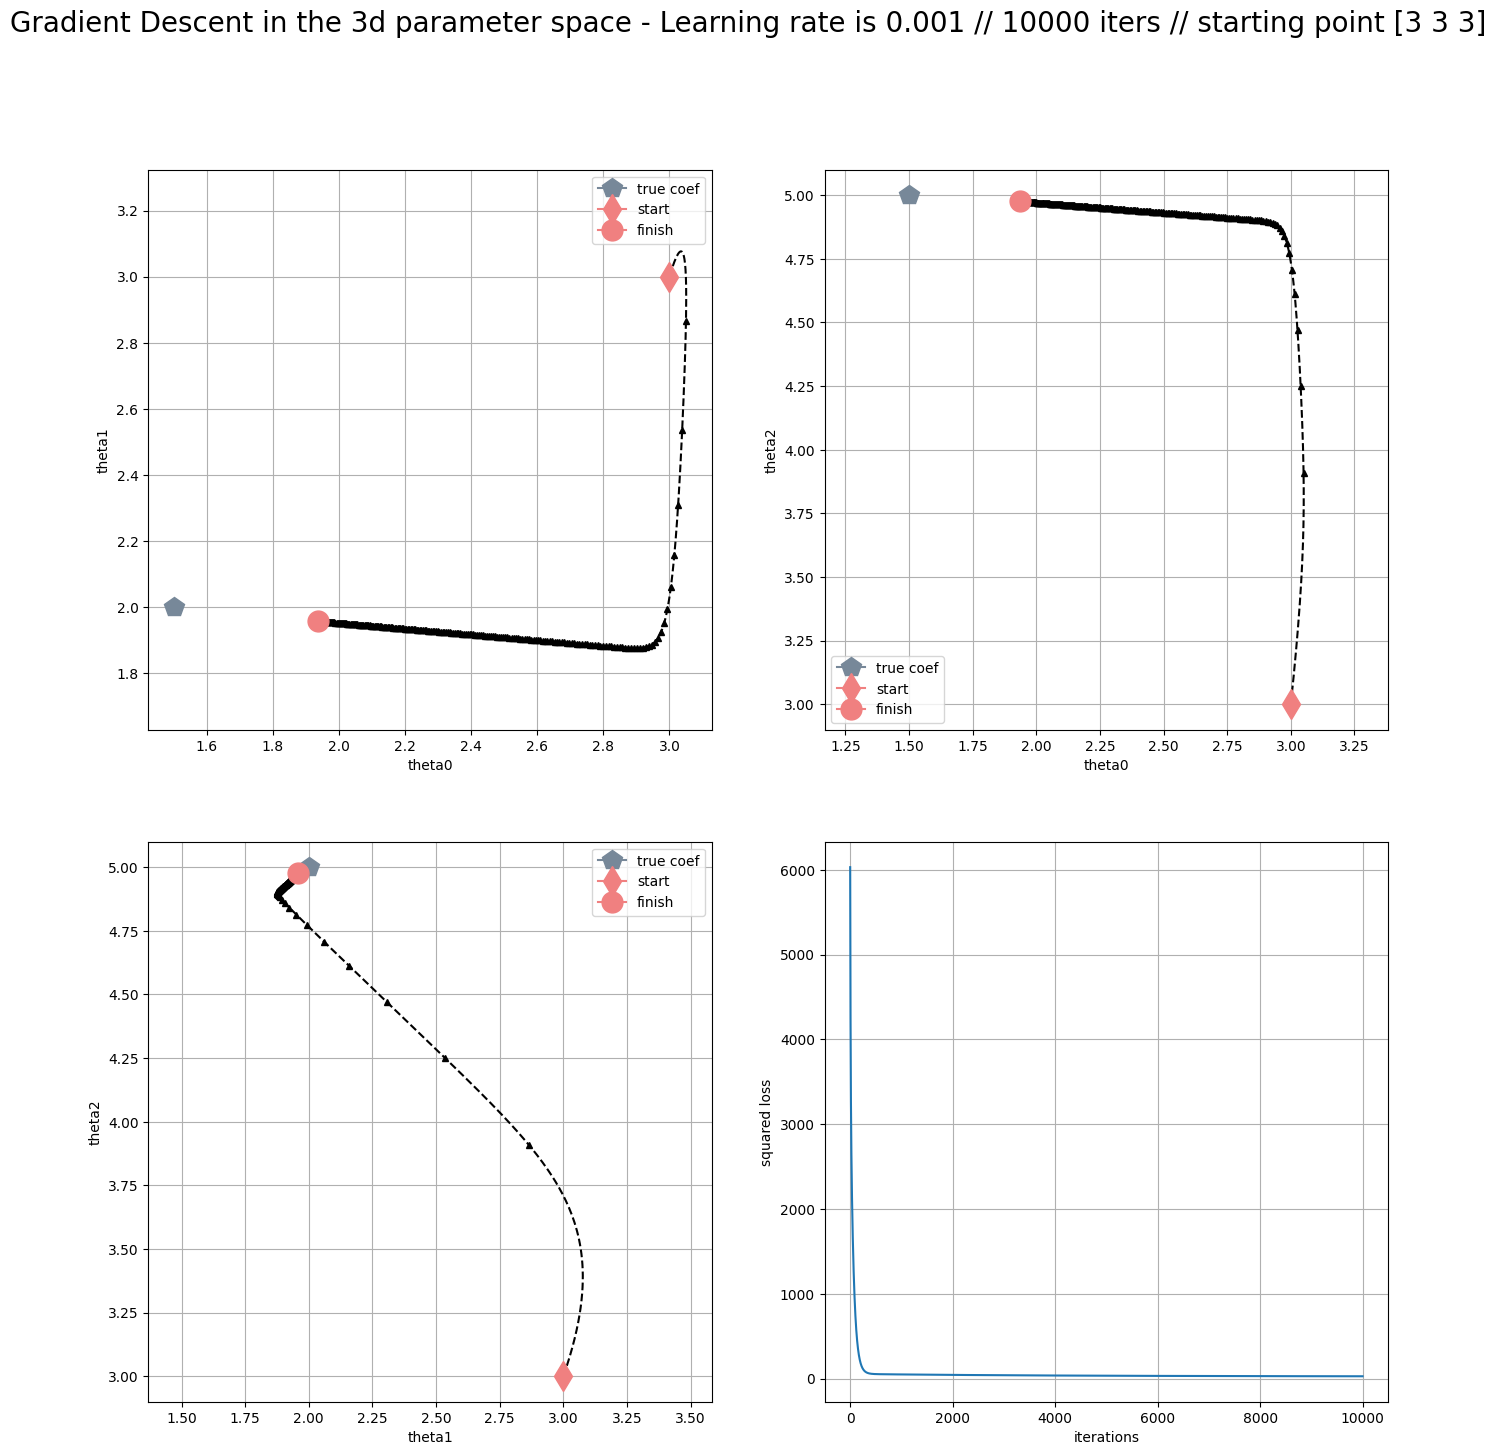

In [14]:
theta_path, loss_vec = gradient_descent(learning_rate, num_iter, theta_initial)

plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial)

## Stochastic Gradient Descent
Rather than average the gradients across the whole dataset before taking a step, we will now take a step for every datapoint.  Each step will be somewhat of an "overreaction" but they should average out.  

## Exercise
The below code runs Stochastic Gradient descent, but runs through the data in the same order every time.  

1. Run the code and plot the graphs.  What do you notice?
2. Modify the code so that it randomly re-orders the data.  How do the sample trajectories compare?

In [18]:
def stochastic_gradient_descent(learning_rate, num_iter, theta_initial):

    ## Initialization steps
    theta = theta_initial

    # below are different in STOCHASTIC gradient descent
    theta_path = np.zeros(((num_iter*num_obs)+1,3))
    theta_path[0,:] = theta_initial
    loss_vec = np.zeros(num_iter*num_obs)

    ## Main SGD loop
    count = 0
    for i in range(num_iter):
        for j in range(num_obs):
            count+=1
            y_pred = np.dot(theta.T,x_mat.T)
            loss_vec[count-1] = np.sum((y-y_pred)**2)
            grad_vec = (y[j]-y_pred[j])*(x_mat[j,:])
            theta = theta + learning_rate*grad_vec
            theta_path[count,:]=theta

    return theta_path, loss_vec

In [19]:
## Parameters to play with
learning_rate = 1e-4  # 0.0001
num_iter = 100
theta_initial = np.array([3,3,3])

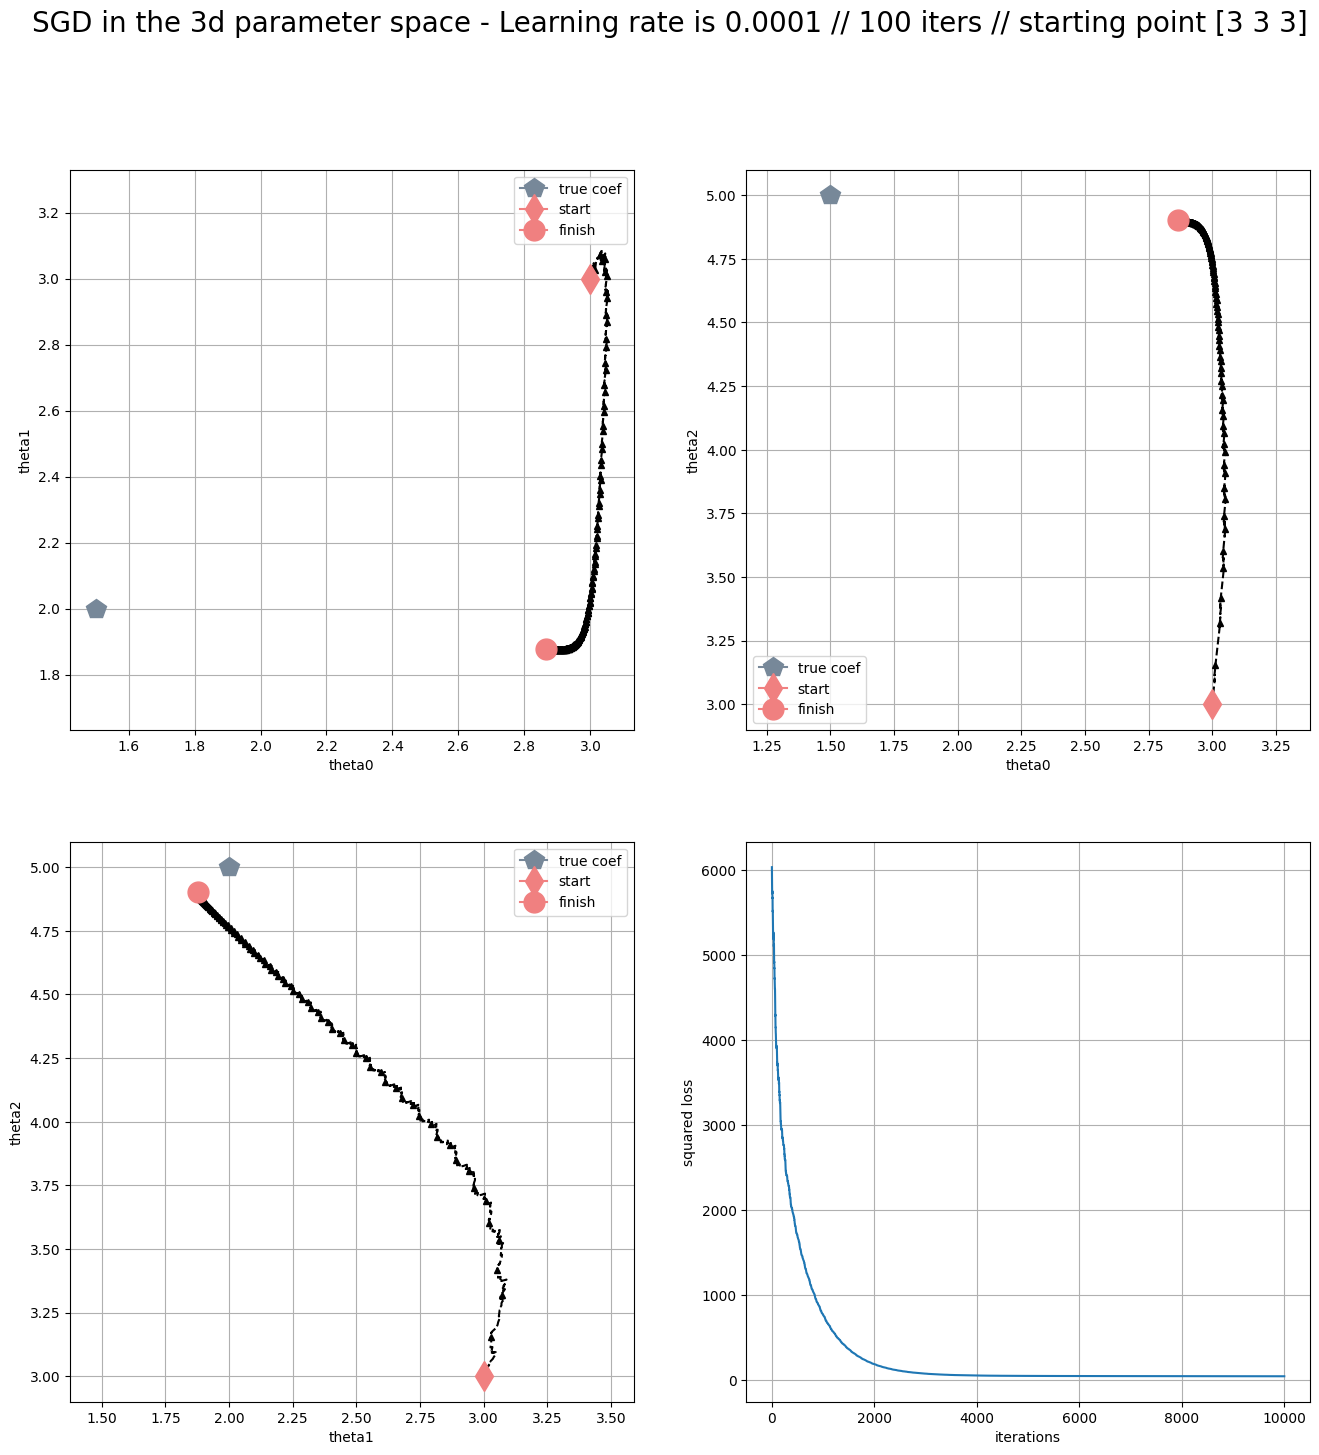

In [20]:
theta_path, loss_vec = stochastic_gradient_descent(learning_rate, num_iter, theta_initial)

plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial, 'SGD')

Play with the parameters below and observe the trajectory it results in

In [21]:
## Parameters to play with

learning_rate = 1e-5  # 0.00001

num_iter = 200

theta_initial = np.array([3,3,3])

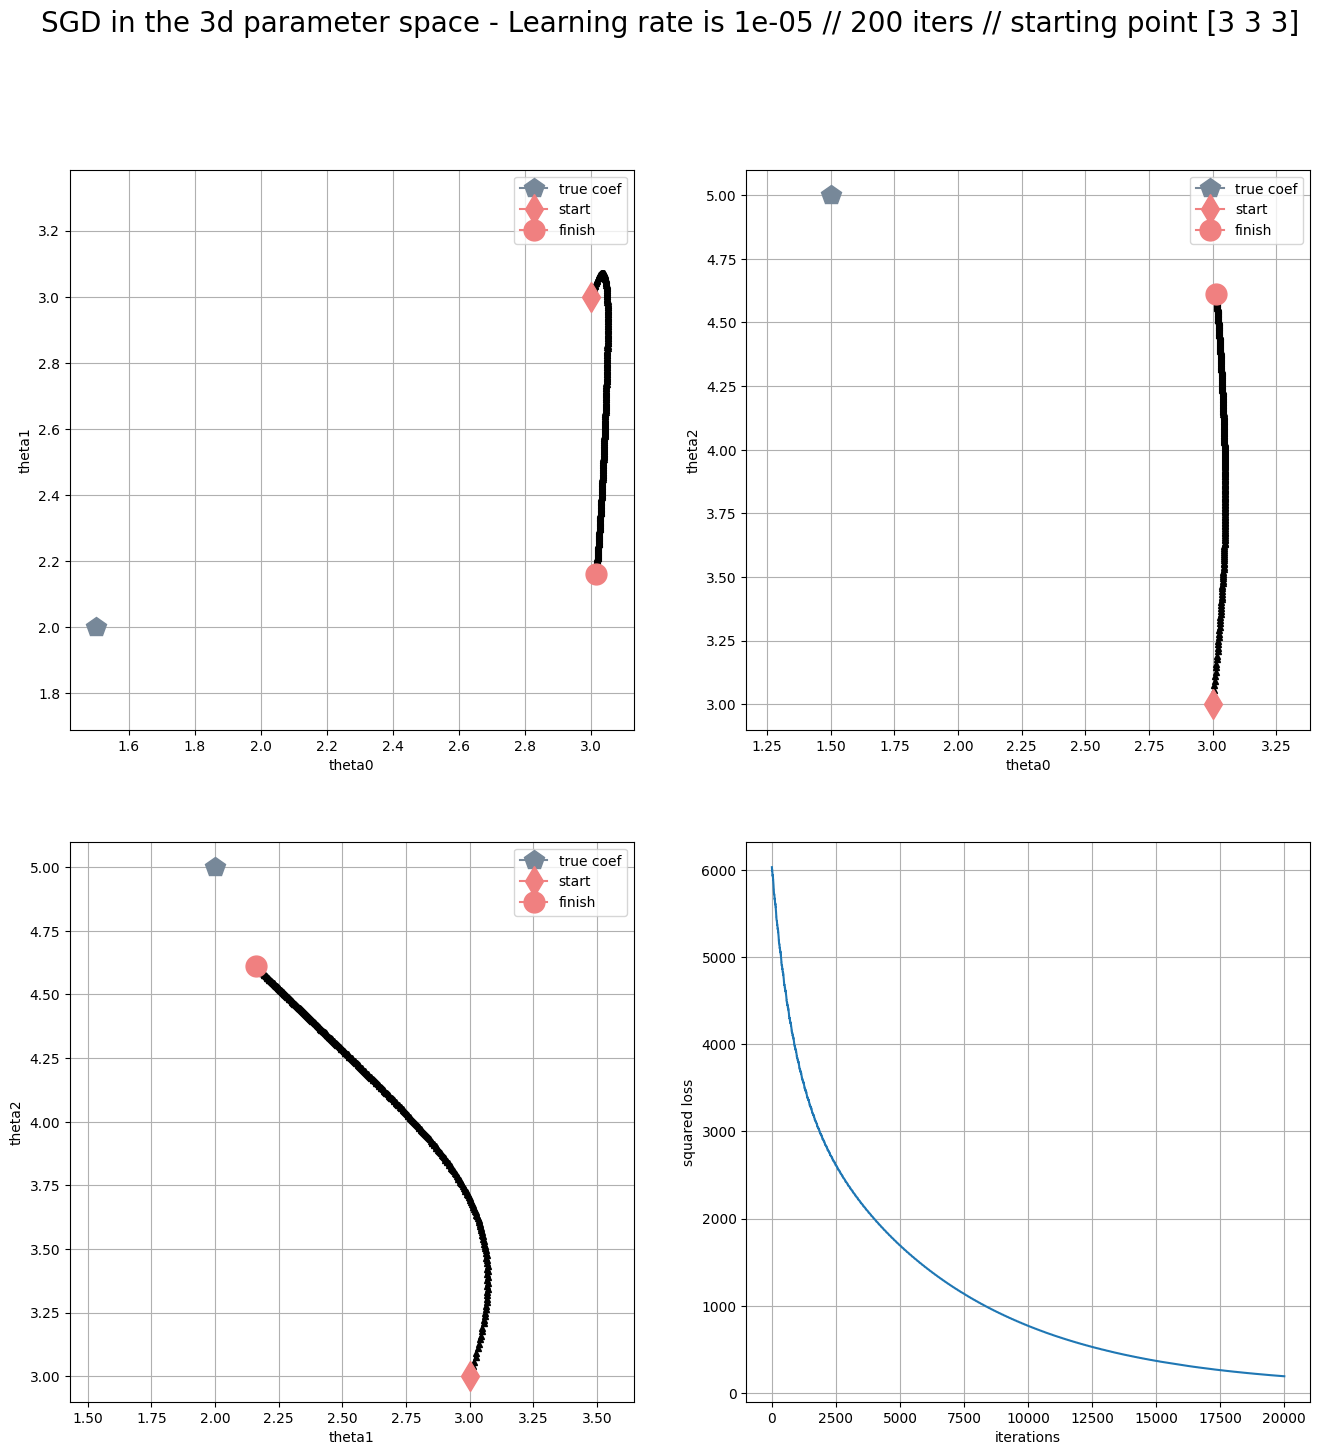

In [22]:
theta_path, loss_vec = stochastic_gradient_descent(learning_rate, num_iter, theta_initial)

plot_all(theta_path, loss_vec, learning_rate, num_iter, theta_initial, 'SGD')

Comment on the changes: when (a) learning rate is increased; (b) learning rate is decreased, while number of iterations remain the same as 100

Attempt **Batch Gradient Descent** and **Mini-batch Gradient Descent**. Observe the different performance among all types of gradient descent.

Running Batch Gradient Descent...


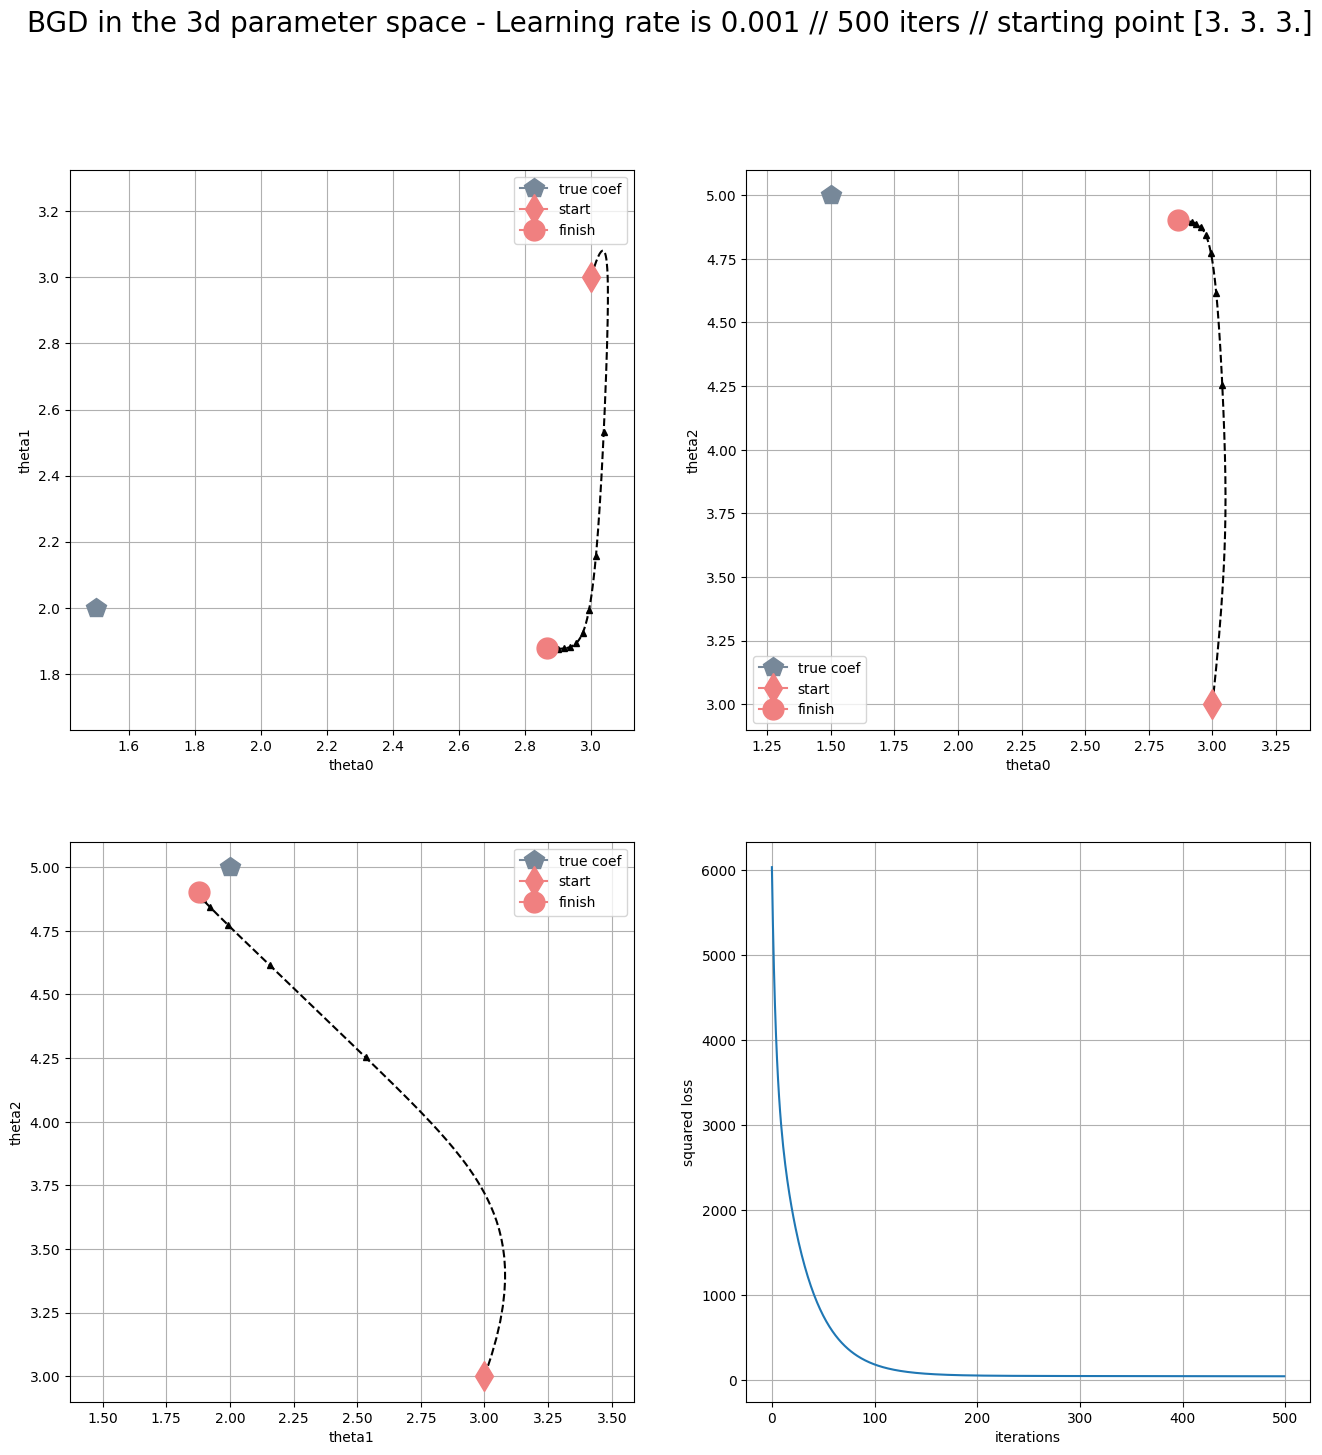

In [24]:
def batch_gradient_descent(learning_rate, num_iter, theta_initial, x_mat, y, num_obs):
    ## Initialization steps
    theta = theta_initial
    num_features = x_mat.shape[1] # Number of features (including bias)

    # In BGD, updates happen once per epoch
    theta_path = np.zeros((num_iter + 1, num_features))
    theta_path[0, :] = theta_initial
    loss_vec = np.zeros(num_iter)

    ## Main BGD loop
    for i in range(num_iter):
        # Predict for all samples
        y_pred = np.dot(x_mat, theta) # x_mat is (num_obs, num_features), theta is (num_features,)
                                       # result is (num_obs,)

        # Calculate the loss (Sum of Squared Errors) for the entire batch
        loss_vec[i] = np.sum((y - y_pred)**2)

        # Calculate the gradient using ALL samples
        # The gradient for linear regression is: -2/N * X_T * (y - y_pred)
        # where N is num_obs
        # Or, more simply, sum of (error * feature_value) for each feature
        # (y - y_pred) is (num_obs,)
        # x_mat is (num_obs, num_features)
        # np.dot(x_mat.T, (y - y_pred)) gives (num_features,)
        grad_vec = -2/num_obs * np.dot(x_mat.T, (y - y_pred))

        # Update theta
        # Note the minus sign for gradient descent (minimizing loss)
        theta = theta - learning_rate * grad_vec

        # Store theta after update
        theta_path[i+1, :] = theta

    return theta_path, loss_vec

# --- BGD Parameters and Execution ---
print("Running Batch Gradient Descent...")
bgd_learning_rate = 1e-3 # Often can use a larger learning rate than SGD
bgd_num_iter = 500 # Might need more iterations depending on learning rate
bgd_theta_initial = np.array([3.0, 3.0, 3.0]) # Ensure float type

bgd_theta_path, bgd_loss_vec = batch_gradient_descent(
    bgd_learning_rate, bgd_num_iter, bgd_theta_initial, x_mat, y, num_obs
)

plot_all(bgd_theta_path, bgd_loss_vec, bgd_learning_rate, bgd_num_iter, bgd_theta_initial, 'BGD')


Running Mini-Batch Gradient Descent...


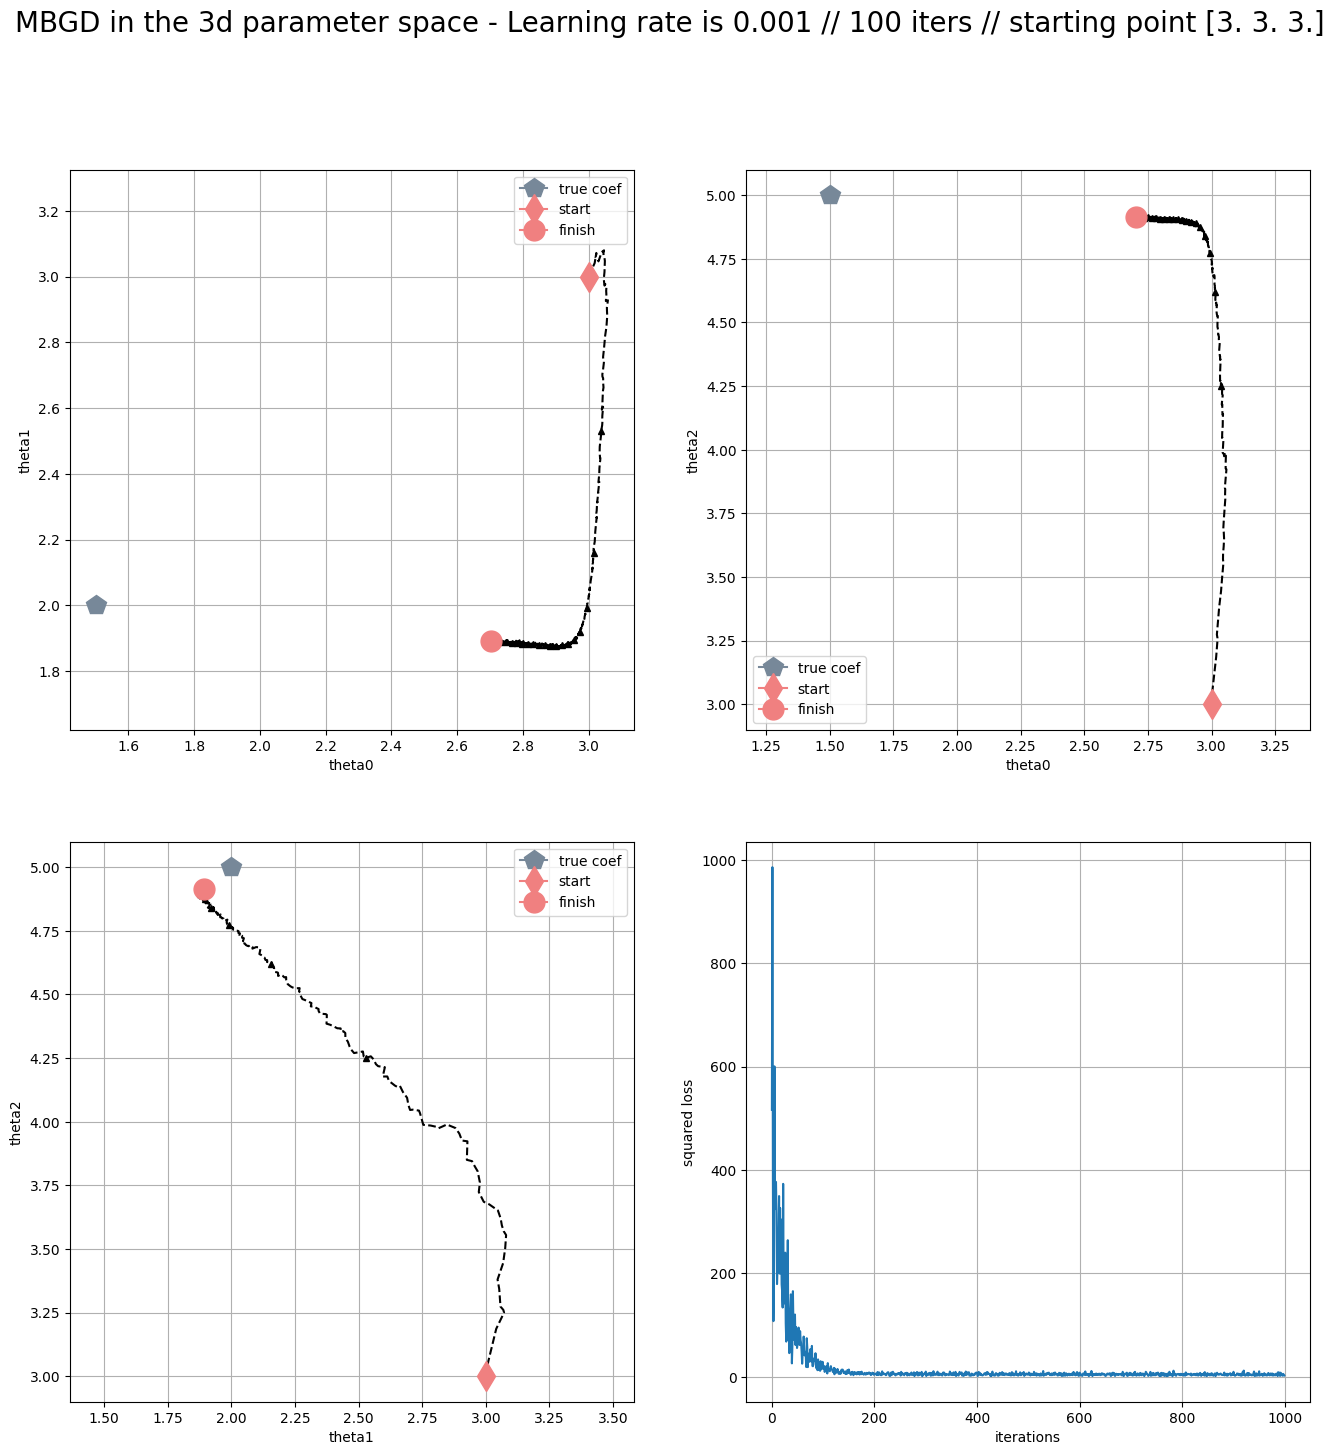

In [25]:
def mini_batch_gradient_descent(learning_rate, num_iter, theta_initial, x_mat, y, num_obs, batch_size):
    ## Initialization steps
    theta = theta_initial
    num_features = x_mat.shape[1]

    # Calculate number of updates per epoch
    num_batches_per_epoch = int(np.ceil(num_obs / batch_size))
    total_updates = num_iter * num_batches_per_epoch

    theta_path = np.zeros((total_updates + 1, num_features))
    theta_path[0, :] = theta_initial
    loss_vec = np.zeros(total_updates)

    update_count = 0
    for i in range(num_iter):
        # Shuffle the data for each epoch
        # This ensures randomness in mini-batches
        shuffled_indices = np.random.permutation(num_obs)
        X_shuffled = x_mat[shuffled_indices]
        y_shuffled = y[shuffled_indices]

        for j in range(0, num_obs, batch_size):
            end_idx = min(j + batch_size, num_obs)
            X_batch = X_shuffled[j:end_idx]
            y_batch = y_shuffled[j:end_idx]
            current_batch_size = len(X_batch)

            # Predict for the current mini-batch
            y_pred_batch = np.dot(X_batch, theta)

            # Calculate loss for the current mini-batch
            loss_vec[update_count] = np.sum((y_batch - y_pred_batch)**2)

            # Calculate gradient for the current mini-batch
            grad_vec = -2/current_batch_size * np.dot(X_batch.T, (y_batch - y_pred_batch))

            # Update theta
            theta = theta - learning_rate * grad_vec

            update_count += 1
            theta_path[update_count, :] = theta

    # Trim arrays if update_count didn't reach total_updates due to early stopping or calculation error
    theta_path = theta_path[:update_count + 1]
    loss_vec = loss_vec[:update_count]

    return theta_path, loss_vec


# --- MBGD Parameters and Execution ---
print("\nRunning Mini-Batch Gradient Descent...")
mbgd_learning_rate = 1e-3
mbgd_num_iter = 100 # Number of full passes over the dataset (epochs)
mbgd_batch_size = 10 # Common batch sizes: 10, 32, 64, 128, 256
mbgd_theta_initial = np.array([3.0, 3.0, 3.0])

mbgd_theta_path, mbgd_loss_vec = mini_batch_gradient_descent(
    mbgd_learning_rate, mbgd_num_iter, mbgd_theta_initial, x_mat, y, num_obs, mbgd_batch_size
)

plot_all(mbgd_theta_path, mbgd_loss_vec, mbgd_learning_rate, mbgd_num_iter, mbgd_theta_initial, 'MBGD')


Running Stochastic Gradient Descent (Corrected)...


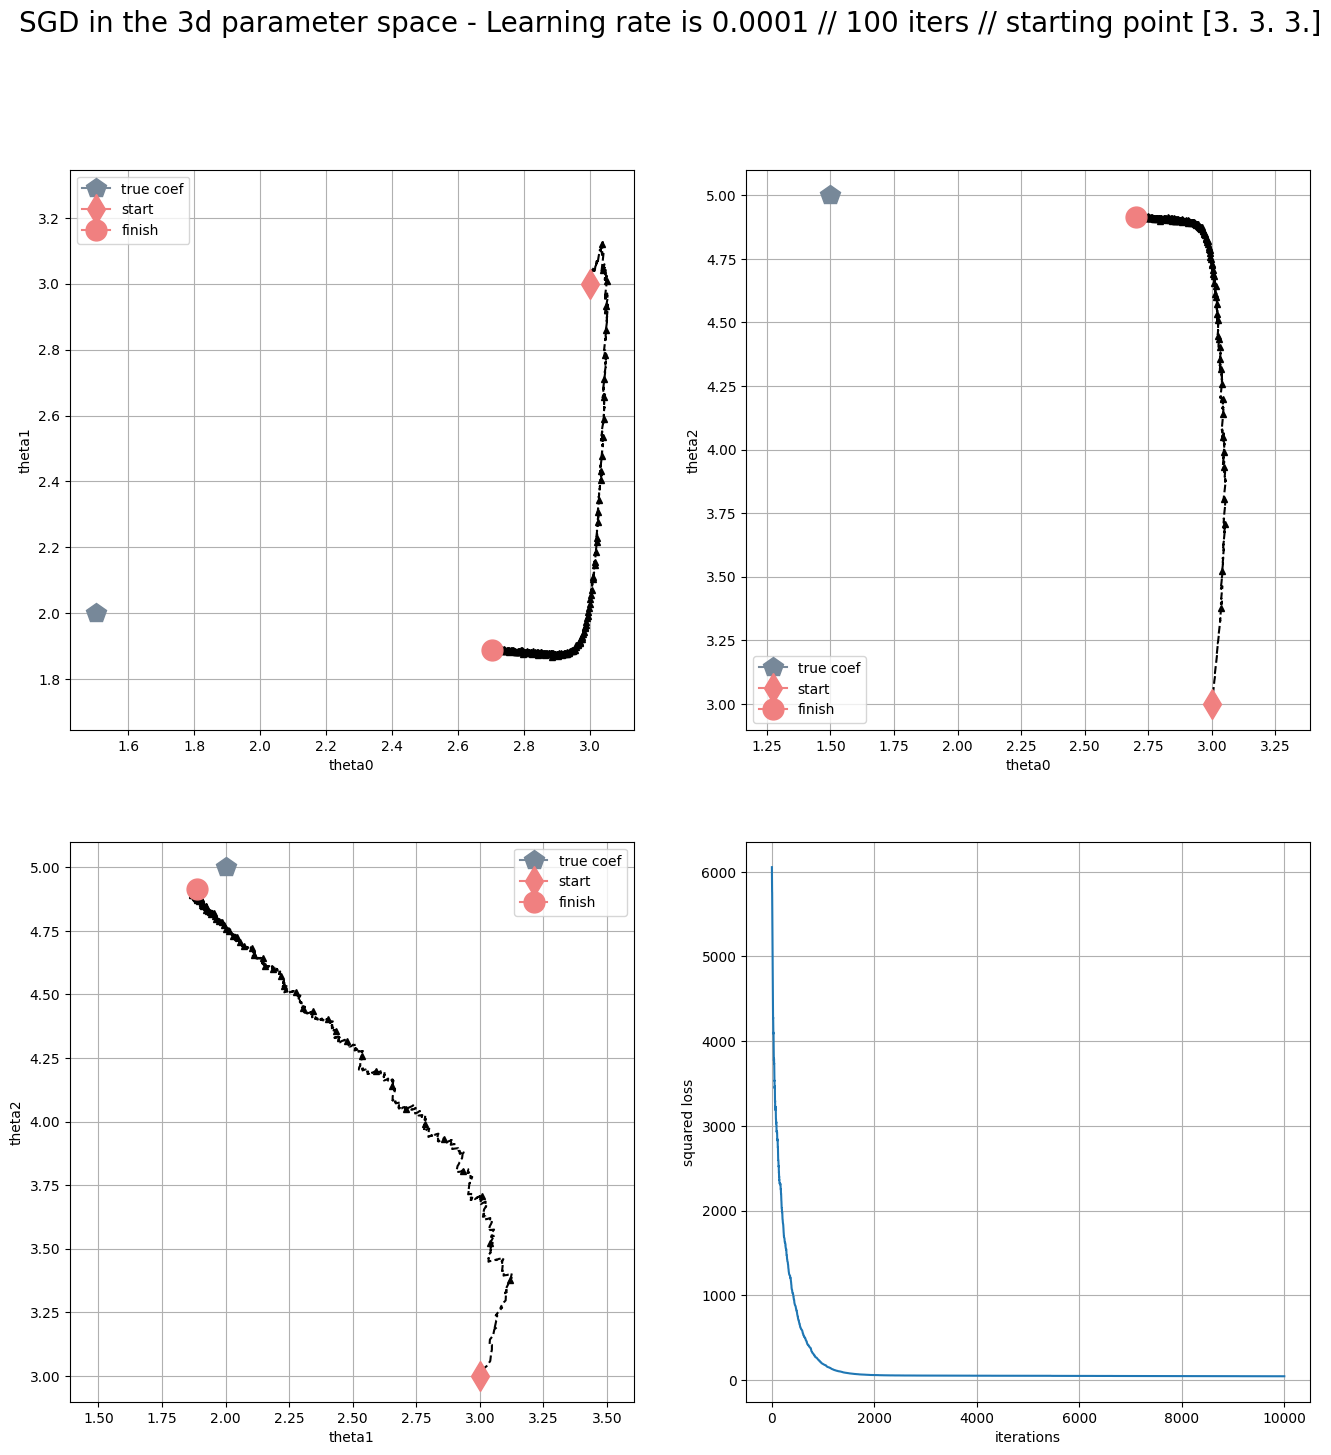

In [26]:
def stochastic_gradient_descent_corrected(learning_rate, num_iter, theta_initial, x_mat, y, num_obs):
    ## Initialization steps
    theta = theta_initial
    num_features = x_mat.shape[1]

    # These lengths are suitable for tracking after each sample update
    theta_path = np.zeros(((num_iter * num_obs) + 1, num_features))
    theta_path[0, :] = theta_initial
    # loss_vec will store the loss based on the current theta *after* that sample update
    loss_vec = np.zeros(num_iter * num_obs)

    ## Main SGD loop
    count = 0 # This count tracks the total number of parameter updates
    for i in range(num_iter): # Number of epochs
        # Shuffle data for each epoch for better convergence
        shuffled_indices = np.random.permutation(num_obs)
        X_shuffled = x_mat[shuffled_indices]
        y_shuffled = y[shuffled_indices]

        for j in range(num_obs): # Iterate through each sample
            # Get the current sample
            X_sample = X_shuffled[j, :] # Shape (num_features,)
            y_sample = y_shuffled[j]    # Scalar

            # Predict for the single sample
            # Note: y_pred here is for the *entire* dataset to calculate overall loss for tracking.
            # But the gradient is for the single sample.
            # To get a more typical "single sample loss" for tracking, calculate it just for the sample.
            y_pred_single = np.dot(X_sample, theta)

            # The gradient for the single sample
            # (y_sample - y_pred_single) is a scalar error for this sample
            # X_sample is (num_features,)
            # grad_vec will be (num_features,)
            grad_vec = -2 * (y_sample - y_pred_single) * X_sample

            # Update theta
            theta = theta - learning_rate * grad_vec

            # Store theta after update
            count += 1
            theta_path[count, :] = theta

            # Calculate and store the *overall* loss for tracking purposes
            # This is a bit unusual for SGD, as SGD is noisy per update.
            # Usually, you'd calculate overall loss after each epoch.
            # But following your teacher's pattern:
            current_full_y_pred = np.dot(x_mat, theta) # Predict on ALL data with current theta
            loss_vec[count - 1] = np.sum((y - current_full_y_pred)**2)


    return theta_path, loss_vec

# --- Original SGD Parameters and Execution ---
print("\nRunning Stochastic Gradient Descent (Corrected)...")
sgd_learning_rate = 1e-4
sgd_num_iter = 100
sgd_theta_initial = np.array([3.0, 3.0, 3.0])

sgd_theta_path, sgd_loss_vec = stochastic_gradient_descent_corrected(
    sgd_learning_rate, sgd_num_iter, sgd_theta_initial, x_mat, y, num_obs
)

plot_all(sgd_theta_path, sgd_loss_vec, sgd_learning_rate, sgd_num_iter, sgd_theta_initial, 'SGD')